# College Football Spread Betting Model

## Imports

In [15]:
import sqlite3
import pandas as pd
import numpy as np
import os
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from opponent_adjustments import get_opponent_adjustments
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
import warnings
import math
from tqdm import tqdm
import optuna
import Model_Functions as MF

## Config Inputs

In [24]:
# Config - Major Inputs
DB_PATH = "cfb_data.db"
PRE_GAME_ELO_CSV_PATH = 'games_with_pregame_elo.csv'
#Define RP metrics to load and use
RP_METRICS_TO_USE =['usage','percentPPA']
# Define dfault value for missing RP data (e.g., average)
DEFAULT_RP_VALUE = 0.5
# Define how many weeks RP features should be active
RP_ACTIVE_WEEKS = 4
#Betting Parameters
BET_THRESHOLD = 1.5
WIN_PAYOUT = 0.909
LOSS_AMOUNT = 1
# EWMA Parameters
EWMA_SPAN = 5
min_periods_for_ewma = max(1, EWMA_SPAN // 2)
# Train / Test Split Years
TRAIN_END_SEASON = 2020
VALIDATION_END_SEASON = 2022
TEST_START_SEASON = VALIDATION_END_SEASON + 1
# XG Boost Params
# Define XGBoost parameters (use reasonable defaults or slightly tuned values)
# We are NOT tuning hyperparameters here, just evaluating feature sets
XGB_PARAMS = {
    'objective': 'reg:squarederror', # Regression task
    'eval_metric': 'rmse',           # Evaluation metric for XGBoost internal use
    'eta': 0.1,                      # Learning rate
    'max_depth': 5,                  # Max tree depth (control complexity)
    'subsample': 0.8,                # Fraction of samples used per tree
    'colsample_bytree': 0.8,         # Fraction of features used per tree
    'seed': 42,
    'nthread': -1, # Use all available CPU threads
    'device': 'cuda'
    # Enable internal NaN handling if using non-imputed data:
    # 'missing': np.nan # Tells XGBoost to handle NaNs
}
NUM_BOOST_ROUNDS = 100 # Number of boosting rounds (trees)

# Val Required Cols
VAL_REQUIRED_COLS = ['avg_opening_spread', 'home_points', 'away_points', 'neutral_site', 'id', 'season', 'week', 'home_team', 'away_team', 'home_pregame_elo_calc', 'away_pregame_elo_calc']

In [3]:
# RUN IF USING GOOGLE COLAB
MF.mount_with_colab()


KeyboardInterrupt



## Phase 1: Data Foundation and Feature Engineering

In [4]:
# Load and Pre-Process Games Data
games_df = MF.preprocess_games_data(MF.load_games_data(DB_PATH))
# Add in Returning Production Data
rp_df = MF.preprocess_returning_prod_data(MF.load_returning_prod_data(DB_PATH, RP_METRICS_TO_USE), RP_METRICS_TO_USE, DEFAULT_RP_VALUE)
# Load Pre-Calculated ELO Ratings
pre_game_elo_df = MF.load_ELO_ratings(PRE_GAME_ELO_CSV_PATH)
# Merge Games and ELO Data
master_df = MF.merge_elo_to_games(games_df, pre_game_elo_df)
# Merge Returning Production to Games
master_df = MF.merge_returning_production_to_games(master_df, rp_df, RP_METRICS_TO_USE, DEFAULT_RP_VALUE)
# Add Opponent Adjustments to the Master DF
master_df = MF.add_opponent_adjustments(master_df)
# Drop Missing Targets and Sort Chronologically
master_df = MF.drop_missing_target_sort_chronologically(master_df)

Connecting to database: cfb_data.db
Loading ALL games data (including advanced stats)...
Loaded 9816 completed games with 142 columns.
Database connection closed.
Converting relevant columns to numeric...
Missing value check (post-numeric conversion):
  Column 'avg_closing_spread' missing: 0.95%
  Column 'home_points' missing: 0.00%
  Column 'away_points' missing: 0.00%
Loading returning production data (['usage', 'percentPPA'])...
Loaded 1420 returning production records.
Database connection closed.
Preprocessing returning production data...
Filling NaNs in RP data with default: 0.5
Loading pre-game Elo ratings from: games_with_pregame_elo.csv
Loaded Elo ratings for 9816 games.
Loaded pre-game Elo ratings.
Merging games data with pre-game Elo ratings...
Merging returning production data...
Filling NaNs in merged RP column 'home_rp_usage' with 0.5
Filling NaNs in merged RP column 'home_rp_percentPPA' with 0.5
Filling NaNs in merged RP column 'away_rp_usage' with 0.5
Filling NaNs in mer

c:\Users\austi\Documents\Local Docs\github\BettingModels\Model_Functions.py:267: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  master_df[col].fillna(DEFAULT_RP_VALUE, inplace=True)



Creating hybrid league average columns...

Calculating lagged expanding team averages...


c:\Users\austi\Documents\Local Docs\github\BettingModels\opponent_adjustments.py:146: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[prev_season_col].fillna(0, inplace=True)
c:\Users\austi\Documents\Local Docs\github\BettingModels\opponent_adjustments.py:162: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values a

Filling initial team NaNs with 0.
DataFrame shape after revised merging: (9816, 298)

Applying Opponent Adjustments with Hybrid League Average...

Hybrid Opponent Adjustments Applied.
Dropping potentially duplicated columns: ['id_y', 'season_type_y', 'completed_y', 'neutral_site_y', 'conference_game_y', 'attendance_y', 'home_conference_y', 'home_division_y', 'home_points_y', 'home_post_win_prob_y', 'home_pregame_elo_y', 'home_postgame_elo_y', 'away_conference_y', 'away_division_y', 'away_points_y', 'away_post_win_prob_y', 'away_pregame_elo_y', 'away_postgame_elo_y', 'avg_closing_spread_y', 'avg_closing_total_y', 'avg_opening_spread_y', 'avg_opening_total_y', 'home_offense_plays_y', 'home_offense_drives_y', 'home_offense_ppa_y', 'home_offense_totalPPA_y', 'home_offense_successRate_y', 'home_offense_explosiveness_y', 'home_offense_powerSuccess_y', 'home_offense_stuffRate_y', 'home_offense_lineYards_y', 'home_offense_lineYardsTotal_y', 'home_offense_secondLevelYards_y', 'home_offense_seco

c:\Users\austi\Documents\Local Docs\github\BettingModels\opponent_adjustments.py:254: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  team_centric_df[col].fillna(0, inplace=True)


In [5]:
# Inspect Consolidated Data
print("\n--- Master DataFrame Info (Now includes all stats) ---")
master_df.info() # Will show many more columns now

# Displaying head/tail might be too wide, focus on key columns
print("\n--- Master DataFrame Head (Key Columns) ---")
print(master_df[['id', 'season', 'week', 'home_team', 'away_team',
                 'avg_closing_spread', 'avg_opening_spread',
                 'home_pregame_elo_calc', 'away_pregame_elo_calc']].head())

print("\n--- Master DataFrame Tail (Check Sorting - Key Columns) ---")
print(master_df[['id', 'season', 'week', 'home_team', 'away_team',
                 'avg_closing_spread', 'avg_opening_spread',
                 'home_pregame_elo_calc', 'away_pregame_elo_calc']].tail())


--- Master DataFrame Info (Now includes all stats) ---


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9816 entries, 0 to 9815
Columns: 358 entries, id to adj_hybrid_away_defense_passingPlays_explosiveness
dtypes: float64(345), int64(6), object(7)
memory usage: 26.8+ MB

--- Master DataFrame Head (Key Columns) ---
          id  season  week       home_team         away_team  \
0  332410006    2013     1   South Alabama     Southern Utah   
1  332410023    2013     1  San José State  Sacramento State   
2  332410041    2013     1           UConn            Towson   
3  332410062    2013     1         Hawai'i               USC   
4  332410084    2013     1         Indiana     Indiana State   

   avg_closing_spread  avg_opening_spread  home_pregame_elo_calc  \
0          -41.000000                 NaN                 1790.0   
1          -33.000000                 NaN                 1790.0   
2          -20.000000                 NaN                 1790.0   
3           22.833333                 NaN                 1790.0   
4          -

In [6]:
# Define Target Variable and Basic Features
target_variable, basic_features, master_df = MF.define_target_variable_basic_features(master_df)
# Identify Stats to Roll
stats_to_roll = MF.identify_stats_to_roll(EWMA_SPAN)
# Reshape data to team-centric format
team_game_df = MF.reshape_to_team_centric(master_df, stats_to_roll)
# Calculate Lagged EWMAs
team_game_df, ewma_cols_generated = MF.calculate_lagged_ewma(team_game_df, stats_to_roll, EWMA_SPAN, min_periods_for_ewma)
# Merge Back to Master DF
master_df = MF.merge_ewma_to_master_df(master_df, team_game_df, ewma_cols_generated)
# Create Matchup Features
master_df = MF.create_matchup_features(master_df, stats_to_roll)
# Create Returning Production Features
master_df, potential_features, basic_features = MF.create_returning_prod_features(master_df, RP_METRICS_TO_USE, RP_ACTIVE_WEEKS)


Target Variable: 'avg_closing_spread'
Missing values in target ('avg_closing_spread'): 0.95%
Missing values in target after dropping: 0

Basic Features Selected (7):
['home_pregame_elo_calc', 'away_pregame_elo_calc', 'neutral_site', 'conference_game', 'season', 'week', 'elo_diff_calc']
Selected 33 stats for EWMA (span=5).
Reshaping data to team-centric format...
Sorting team-centric data...
Calculating SEASONAL lagged EWMAs (span=5)...
Skipping EWMA for 'offense_lineYards' as column not found in team_game_df.
Skipping EWMA for 'defense_lineYards' as column not found in team_game_df.
Generated 32 EWMA columns.
Merging EWMA features back to master DataFrame...
Creating matchup features (differences)...
Generated 15 SEASONAL matchup difference features.
Created 2 RP difference features.
Created 6 conditionally active RP features (Weeks 1-4).

Updating potential features list...
Total potential features (incl. Seasonal EWMA & Conditional RP): 92


In [7]:
# Identify and Quantify Missing Data in Features
# Use the 'potential_features' list created at the end of Step 3
# If you didn't create it, define it again:
# all_engineered_features = [col for col in master_df.columns if '_ewma_lag1' in col or 'matchup_' in col]
# potential_features = basic_features + all_engineered_features # basic_features defined in step 2

# Calculate missing percentage for features we might use
print(f"Checking missing values for {len(potential_features)} potential features...")
missing_summary = master_df[potential_features].isnull().mean().sort_values(ascending=False) * 100
missing_summary = missing_summary[missing_summary > 0] # Filter to only show columns with missing data

print("\nFeatures with Missing Values (%):")
if missing_summary.empty:
    print("No missing values found in the potential feature set.")
else:
    with pd.option_context('display.max_rows', None): # Ensure all rows are printed
        print(missing_summary)

Checking missing values for 92 potential features...

Features with Missing Values (%):
adj_hybrid_away_offense_passingDowns_explosiveness_ewma_lag1     3.558572
matchup_HO_v_AD_passingDowns_explosiveness                       3.486578
matchup_HO_v_AD_passingPlays_explosiveness                       3.466008
matchup_HO_v_AD_rushingPlays_explosiveness                       3.466008
matchup_HO_v_AD_rushingPlays_ppa                                 3.455724
matchup_HO_v_AD_standardDowns_explosiveness                      3.455724
matchup_HO_v_AD_explosiveness                                    3.445439
matchup_HO_v_AD_successRate                                      3.445439
matchup_HO_v_AD_standardDowns_ppa                                3.445439
matchup_HO_v_AD_passingDowns_ppa                                 3.445439
matchup_HO_v_AD_passingDowns_successRate                         3.445439
matchup_HO_v_AD_ppa                                              3.445439
matchup_HO_v_AD_standard

In [8]:
# Drop FCS Games
master_df = MF.drop_fcs_games(master_df)


--- Filtering Out Games Against FCS Opponents ---
Dropped 1171 games where away_team division is 'fcs'.
Remaining rows in master_df: 8552


## Phase 2: Feature Selection and Training

Splitting data chronologically:
  Training:   Seasons <= 2020
  Validation: Seasons > 2020 and <= 2022

Data Shapes:
  Training Set:   (5583, 446)
  Validation Set: (1467, 446)

Feature matrix shapes:
  X_train: (5583, 92)
  X_val:   (1467, 92)

Temporarily imputing NaNs with training set median for selection analysis...
Temporarily imputed 79 columns.
NaN check after imputation (X_train): 0
NaN check after imputation (X_val):   0

--- Filtering: Low Variance Features ---
Initial feature count: 92
Variance Threshold:    0.005
No features dropped by variance threshold.
Features remaining:    92

--- Filtering: High Missing Values (Check on Original Data) ---
Missing Value Threshold: > 90.0%
No features dropped by high missing value threshold.

--- Analysis: Feature-Target Correlation ---
Top 20 Features correlated with 'avg_closing_spread' (Absolute Value):
elo_diff_calc                                                 0.883600
away_pregame_elo_calc                                       

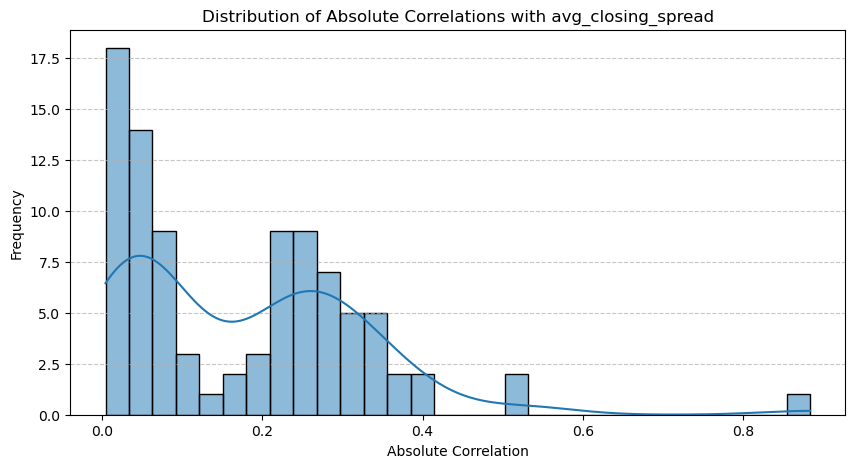


--- Analysis: Feature-Feature Correlation ---
Found 19 pairs with absolute correlation > 0.9

Highly Correlated Pairs (Feature1, Feature2, Correlation):
  - ('away_rp_percentPPA_Wk1_4' [0.079], 'away_rp_usage_Wk1_4' [0.081], 0.9796) -> Suggest dropping: 'away_rp_percentPPA_Wk1_4'
  - ('home_rp_percentPPA_Wk1_4' [0.102], 'home_rp_usage_Wk1_4' [0.107], 0.9783) -> Suggest dropping: 'home_rp_percentPPA_Wk1_4'
  - ('adj_hybrid_away_defense_standardDowns_successRate_ewma_lag1' [0.227], 'adj_hybrid_away_defense_successRate_ewma_lag1' [0.257], 0.9726) -> Suggest dropping: 'adj_hybrid_away_defense_standardDowns_successRate_ewma_lag1'
  - ('adj_hybrid_away_offense_standardDowns_successRate_ewma_lag1' [0.221], 'adj_hybrid_away_offense_successRate_ewma_lag1' [0.263], 0.9713) -> Suggest dropping: 'adj_hybrid_away_offense_standardDowns_successRate_ewma_lag1'
  - ('adj_hybrid_home_defense_standardDowns_successRate_ewma_lag1' [0.197], 'adj_hybrid_home_defense_successRate_ewma_lag1' [0.229], 0.9712) -

c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:28:39] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)



Top 30 Features by XGBoost Importance (Gain):
                                              feature    importance
68                                      elo_diff_calc  17771.910156
69                              home_pregame_elo_calc   6912.831543
64                              away_pregame_elo_calc   5404.645996
54              adj_hybrid_home_offense_ppa_ewma_lag1    747.005737
61      adj_hybrid_home_offense_successRate_ewma_lag1    720.155640
22              adj_hybrid_away_offense_ppa_ewma_lag1    677.171570
67                                    conference_game    611.307983
39              adj_hybrid_home_defense_ppa_ewma_lag1    531.493591
90                                             season    512.752625
14      adj_hybrid_away_defense_successRate_ewma_lag1    497.803619
27  adj_hybrid_away_offense_standardDowns_ppa_ewma...    490.125824
50  adj_hybrid_home_offense_passingDowns_successRa...    485.437653
87                                       neutral_site    467.711456
7

c:\Users\austi\Documents\Local Docs\github\BettingModels\Model_Functions.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(30), palette='viridis')


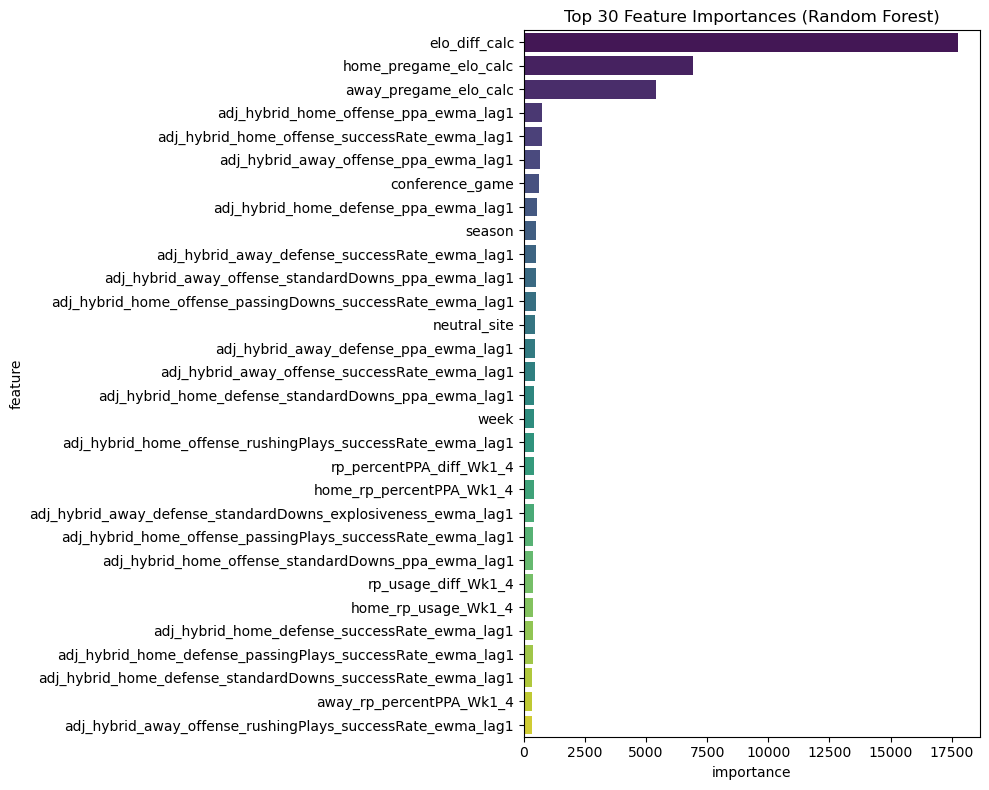


Features remaining after initial filtering & analysis: 92

--- Phase 2, Step 1 (Initial Analysis/Filtering) Complete ---

Defined 6 candidate feature sets:
  - A_Basic: 7 features
  - B_Top50_Corr: 50 features
  - C_Top50_RF_Importance: 50 features
  - D_Reduced_Correlation: 77 features
  - E_All_Initial_Filtered: 92 features
  - F_Top50_RF_plus_Basic: 50 features

--- Evaluating Feature Set: A_Basic (7 features) ---
Betting simulation failed for A_Basic: simulate_betting() missing 3 required positional arguments: 'WIN_PAYOUT', 'LOSS_AMOUNT', and 'BET_THRESHOLD'
  RMSE: 6.0935, MAE: 4.7600, Correlation: 0.9014, Bias: 0.5570, Time: 0.1s

--- Evaluating Feature Set: B_Top50_Corr (50 features) ---


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:28:40] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:28:40] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


Betting simulation failed for B_Top50_Corr: simulate_betting() missing 3 required positional arguments: 'WIN_PAYOUT', 'LOSS_AMOUNT', and 'BET_THRESHOLD'
  RMSE: 5.4521, MAE: 4.1976, Correlation: 0.9216, Bias: -0.2700, Time: 0.5s

--- Evaluating Feature Set: C_Top50_RF_Importance (50 features) ---


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:28:41] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


Betting simulation failed for C_Top50_RF_Importance: simulate_betting() missing 3 required positional arguments: 'WIN_PAYOUT', 'LOSS_AMOUNT', and 'BET_THRESHOLD'
  RMSE: 5.3715, MAE: 4.1192, Correlation: 0.9239, Bias: 0.3060, Time: 0.4s

--- Evaluating Feature Set: D_Reduced_Correlation (77 features) ---


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:28:41] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


Betting simulation failed for D_Reduced_Correlation: simulate_betting() missing 3 required positional arguments: 'WIN_PAYOUT', 'LOSS_AMOUNT', and 'BET_THRESHOLD'
  RMSE: 5.3621, MAE: 4.1452, Correlation: 0.9242, Bias: 0.3432, Time: 0.7s

--- Evaluating Feature Set: E_All_Initial_Filtered (92 features) ---


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:28:42] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


Betting simulation failed for E_All_Initial_Filtered: simulate_betting() missing 3 required positional arguments: 'WIN_PAYOUT', 'LOSS_AMOUNT', and 'BET_THRESHOLD'
  RMSE: 5.3561, MAE: 4.1401, Correlation: 0.9244, Bias: 0.3164, Time: 0.7s

--- Evaluating Feature Set: F_Top50_RF_plus_Basic (50 features) ---


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:28:43] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


Betting simulation failed for F_Top50_RF_plus_Basic: simulate_betting() missing 3 required positional arguments: 'WIN_PAYOUT', 'LOSS_AMOUNT', and 'BET_THRESHOLD'
  RMSE: 5.4270, MAE: 4.1769, Correlation: 0.9223, Bias: 0.3401, Time: 0.4s

--- Feature Set Evaluation Summary ---
              Set Name  Num Features   RMSE    MAE Correlation    Bias Betting Units Betting Win Rate Betting ROI Eval Time (s)
E_All_Initial_Filtered            92 5.3561 4.1401      0.9244  0.3164           nan             nan%        nan%           0.7
 D_Reduced_Correlation            77 5.3621 4.1452      0.9242  0.3432           nan             nan%        nan%           0.7
 C_Top50_RF_Importance            50 5.3715 4.1192      0.9239  0.3060           nan             nan%        nan%           0.4
 F_Top50_RF_plus_Basic            50 5.4270 4.1769      0.9223  0.3401           nan             nan%        nan%           0.4
          B_Top50_Corr            50 5.4521 4.1976      0.9216 -0.2700           na

In [9]:
# Pepare Data and do Temporal Split
y_train, X_train, y_val, X_val, X_train_analysis, X_val_analysis, val_df, train_df = MF.temporal_split(TRAIN_END_SEASON, VALIDATION_END_SEASON, master_df, target_variable, potential_features)
# Do Initial Filtering
current_features = MF.perform_initial_filtering(X_train_analysis, X_train, train_df)
# Perform the Correlation Analysis
features_to_consider_dropping_corr, correlations_abs = MF.perform_target_correlation_analysis(X_train_analysis, y_train, current_features, target_variable)
# Perform Model Based Importance Analysis
features_after_initial_analysis, feature_importance_df = MF.perform_model_based_importance(X_train, X_train_analysis, y_train, current_features)
# Define Candidate Feature Sets
candidate_feature_sets = MF.define_candidate_feature_sets(basic_features, features_after_initial_analysis, features_to_consider_dropping_corr, feature_importance_df, correlations_abs)
# Run Feature Set Evaluation
all_results = MF.run_feature_set_evaluation(candidate_feature_sets, XGB_PARAMS, NUM_BOOST_ROUNDS, X_train, y_train, X_val, y_val, val_df, VAL_REQUIRED_COLS)
# Present Feature Set Evaluation Results
results_df = MF.present_feature_set_evaluation_results(all_results)

## Phase 3: Model Selection and Training

In [10]:
# Select Best Feature SEt
best_features = MF.select_best_feature_set(results_df, candidate_feature_sets, X_train, X_val)

Selected best feature set for tuning: 'E_All_Initial_Filtered' (92 features)
Using feature shapes: X_train_best=(5583, 92), X_val_best=(1467, 92)


In [11]:
# Run Optuna Study - LONG RUNNING CELL
study_hp = MF.run_optuna_study(X_train, X_val, y_train, y_val, val_df, best_features, VAL_REQUIRED_COLS, WIN_PAYOUT, LOSS_AMOUNT, BET_THRESHOLD)

[I 2025-06-05 13:28:53,130] A new study created in memory with name: XGBoost Spread Prediction NaN



Starting Optuna hyperparameter search (100 trials)...


  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:28:53] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:28:53,600] Trial 0 finished with value: 5.499300243883352 and parameters: {'eta': 0.2527921537015445, 'max_depth': 3, 'subsample': 0.6167891711661719, 'colsample_bytree': 0.7820703755844167, 'min_child_weight': 5, 'gamma': 0.10036243181324328, 'lambda': 5.681179266749359e-07, 'alpha': 2.3526689037696106e-05}. Best is trial 0 with value: 5.499300243883352.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:28:53] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:28:54,935] Trial 1 finished with value: 5.458851851982326 and parameters: {'eta': 0.016329968465489623, 'max_depth': 5, 'subsample': 0.5146704628442547, 'colsample_bytree': 0.679538946745448, 'min_child_weight': 9, 'gamma': 0.17145892720291622, 'lambda': 0.008054342559668916, 'alpha': 0.08629476745456843}. Best is trial 1 with value: 5.458851851982326.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:28:54] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:28:59,735] Trial 2 finished with value: 5.605375481283953 and parameters: {'eta': 0.10827422241936759, 'max_depth': 9, 'subsample': 0.6958168988990361, 'colsample_bytree': 0.8490164481269739, 'min_child_weight': 1, 'gamma': 0.02489951379266442, 'lambda': 0.0002212788186929311, 'alpha': 0.007224687232924861}. Best is trial 1 with value: 5.458851851982326.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:28:59] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:29:00,571] Trial 3 finished with value: 5.3940595835732275 and parameters: {'eta': 0.04682950060349026, 'max_depth': 3, 'subsample': 0.6462971995317466, 'colsample_bytree': 0.5260439267770365, 'min_child_weight': 4, 'gamma': 0.33160047146504446, 'lambda': 7.016407187344533e-06, 'alpha': 4.180731500734831e-05}. Best is trial 3 with value: 5.3940595835732275.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:00] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:29:03,634] Trial 4 finished with value: 5.454100376767335 and parameters: {'eta': 0.0562284417665777, 'max_depth': 8, 'subsample': 0.5131024177434401, 'colsample_bytree': 0.9291616884012356, 'min_child_weight': 2, 'gamma': 0.481700590978428, 'lambda': 0.2074572786860828, 'alpha': 1.6121144954235158e-07}. Best is trial 3 with value: 5.3940595835732275.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:03] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:29:04,615] Trial 5 finished with value: 5.319805651209977 and parameters: {'eta': 0.05384319167133243, 'max_depth': 4, 'subsample': 0.6773753003197462, 'colsample_bytree': 0.5303949837124422, 'min_child_weight': 1, 'gamma': 0.4983682430659244, 'lambda': 0.0020636466807818967, 'alpha': 0.013599936749239677}. Best is trial 5 with value: 5.319805651209977.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:04] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:29:05,754] Trial 6 finished with value: 5.335951816828622 and parameters: {'eta': 0.050602968197159696, 'max_depth': 5, 'subsample': 0.9709041251234597, 'colsample_bytree': 0.5897280464994561, 'min_child_weight': 8, 'gamma': 0.01892229294577158, 'lambda': 1.0062216869118192e-05, 'alpha': 0.3208423884269509}. Best is trial 5 with value: 5.319805651209977.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:05] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:29:06,550] Trial 7 finished with value: 5.96622255850017 and parameters: {'eta': 0.013833473360449067, 'max_depth': 3, 'subsample': 0.8534512736647203, 'colsample_bytree': 0.6196204202139852, 'min_child_weight': 9, 'gamma': 0.12045299876360638, 'lambda': 0.6820044811571204, 'alpha': 0.057784099659636955}. Best is trial 5 with value: 5.319805651209977.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:06] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:29:07,416] Trial 8 finished with value: 5.551037604691736 and parameters: {'eta': 0.024028280250336966, 'max_depth': 3, 'subsample': 0.7822534004276429, 'colsample_bytree': 0.9481640073225492, 'min_child_weight': 3, 'gamma': 0.22077770250717815, 'lambda': 0.00019645595230393138, 'alpha': 2.6887821756528223e-05}. Best is trial 5 with value: 5.319805651209977.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:07] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:29:09,155] Trial 9 finished with value: 5.366877963013504 and parameters: {'eta': 0.05263809467850275, 'max_depth': 7, 'subsample': 0.6289016408147471, 'colsample_bytree': 0.6169670658763424, 'min_child_weight': 7, 'gamma': 0.11136925824431376, 'lambda': 3.947930328745338e-08, 'alpha': 0.029057621524054545}. Best is trial 5 with value: 5.319805651209977.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:09] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:29:10,080] Trial 10 finished with value: 5.4782563659333 and parameters: {'eta': 0.13597616748053465, 'max_depth': 6, 'subsample': 0.8089711959491364, 'colsample_bytree': 0.730907993104082, 'min_child_weight': 6, 'gamma': 0.486854021429932, 'lambda': 0.00902560814938452, 'alpha': 0.0018683876163332496}. Best is trial 5 with value: 5.319805651209977.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:10] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:29:11,242] Trial 11 finished with value: 5.3289712933737166 and parameters: {'eta': 0.03147383372252853, 'max_depth': 5, 'subsample': 0.9637796957055049, 'colsample_bytree': 0.5097075010579117, 'min_child_weight': 7, 'gamma': 0.36490414543176525, 'lambda': 8.095476804232317e-06, 'alpha': 0.7992234353089096}. Best is trial 5 with value: 5.319805651209977.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:11] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:29:12,433] Trial 12 finished with value: 5.317631193469423 and parameters: {'eta': 0.028935695382111104, 'max_depth': 5, 'subsample': 0.9636275036585863, 'colsample_bytree': 0.5290005328715043, 'min_child_weight': 6, 'gamma': 0.36632755147195595, 'lambda': 0.0028413209800609842, 'alpha': 0.0012783589322569325}. Best is trial 12 with value: 5.317631193469423.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:12] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:29:13,037] Trial 13 finished with value: 5.387012193477388 and parameters: {'eta': 0.10113640294089057, 'max_depth': 4, 'subsample': 0.8845857503112327, 'colsample_bytree': 0.5003161266693681, 'min_child_weight': 4, 'gamma': 0.3952026512187051, 'lambda': 0.004575541379890596, 'alpha': 0.0009258289975154337}. Best is trial 12 with value: 5.317631193469423.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:13] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:29:15,215] Trial 14 finished with value: 5.308713683526671 and parameters: {'eta': 0.028433681807948363, 'max_depth': 6, 'subsample': 0.7273627824464806, 'colsample_bytree': 0.5758493875187236, 'min_child_weight': 1, 'gamma': 0.41343698605567014, 'lambda': 0.0014880100730040441, 'alpha': 1.0200843423146564e-06}. Best is trial 14 with value: 5.308713683526671.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:15] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:29:18,346] Trial 15 finished with value: 5.328482712509103 and parameters: {'eta': 0.02376585333121913, 'max_depth': 7, 'subsample': 0.7319937237330064, 'colsample_bytree': 0.6830488373317208, 'min_child_weight': 5, 'gamma': 0.28836699847322944, 'lambda': 0.07700368889294062, 'alpha': 2.7825171659756504e-07}. Best is trial 14 with value: 5.308713683526671.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:18] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:29:20,976] Trial 16 finished with value: 5.961228260329321 and parameters: {'eta': 0.010045600778366017, 'max_depth': 6, 'subsample': 0.9053267763743837, 'colsample_bytree': 0.568185356616447, 'min_child_weight': 10, 'gamma': 0.4081250981049516, 'lambda': 0.000880189072797233, 'alpha': 4.9432284217590305e-06}. Best is trial 14 with value: 5.308713683526671.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:21] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:29:23,403] Trial 17 finished with value: 5.327799824012994 and parameters: {'eta': 0.03185646618774393, 'max_depth': 6, 'subsample': 0.824535206285159, 'colsample_bytree': 0.6631748580676161, 'min_child_weight': 3, 'gamma': 0.42905178171954816, 'lambda': 0.03812439415463617, 'alpha': 1.059089424184542e-08}. Best is trial 14 with value: 5.308713683526671.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:23] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:29:26,901] Trial 18 finished with value: 5.399554339800739 and parameters: {'eta': 0.017899085057265344, 'max_depth': 7, 'subsample': 0.7480521489383516, 'colsample_bytree': 0.7864139674661568, 'min_child_weight': 7, 'gamma': 0.3008459951356299, 'lambda': 4.5354792798885846e-05, 'alpha': 1.3510331120099587e-06}. Best is trial 14 with value: 5.308713683526671.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:27] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:29:27,910] Trial 19 finished with value: 5.350303260353699 and parameters: {'eta': 0.03400179040846469, 'max_depth': 4, 'subsample': 0.5712078354465164, 'colsample_bytree': 0.5735365502162416, 'min_child_weight': 6, 'gamma': 0.22928477516800277, 'lambda': 0.0008695530912355895, 'alpha': 0.0003287232412648324}. Best is trial 14 with value: 5.308713683526671.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:28] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:29:30,974] Trial 20 finished with value: 5.479780480895242 and parameters: {'eta': 0.08490415490483617, 'max_depth': 8, 'subsample': 0.9105682059171132, 'colsample_bytree': 0.8596249835448482, 'min_child_weight': 3, 'gamma': 0.35267751154392707, 'lambda': 0.027348643392806012, 'alpha': 1.4153931293402647e-08}. Best is trial 14 with value: 5.308713683526671.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:31] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:29:31,945] Trial 21 finished with value: 5.346018808241735 and parameters: {'eta': 0.07522015458561898, 'max_depth': 4, 'subsample': 0.6726856774318992, 'colsample_bytree': 0.5491349677557813, 'min_child_weight': 1, 'gamma': 0.4432977176182083, 'lambda': 0.0011577798801104587, 'alpha': 0.010507440387825282}. Best is trial 14 with value: 5.308713683526671.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:32] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:29:33,647] Trial 22 finished with value: 5.307561152213133 and parameters: {'eta': 0.040189878203141474, 'max_depth': 5, 'subsample': 0.6936944463068199, 'colsample_bytree': 0.6268858392947754, 'min_child_weight': 2, 'gamma': 0.49394972108359314, 'lambda': 0.003388867640042502, 'alpha': 0.00019672821553508624}. Best is trial 22 with value: 5.307561152213133.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:33] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:29:35,346] Trial 23 finished with value: 5.320546973708453 and parameters: {'eta': 0.023321153978022157, 'max_depth': 5, 'subsample': 0.7291900464333292, 'colsample_bytree': 0.6312640526356389, 'min_child_weight': 2, 'gamma': 0.45221744586786444, 'lambda': 6.290622505805494e-05, 'alpha': 0.0001826706551975346}. Best is trial 22 with value: 5.307561152213133.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:35] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:29:37,093] Trial 24 finished with value: 5.341707269953233 and parameters: {'eta': 0.0387725652557731, 'max_depth': 5, 'subsample': 0.7877619664226473, 'colsample_bytree': 0.7213082001699919, 'min_child_weight': 2, 'gamma': 0.38675674502370394, 'lambda': 0.0002748710727721575, 'alpha': 0.00030175972465180717}. Best is trial 22 with value: 5.307561152213133.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:37] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:29:39,232] Trial 25 finished with value: 5.307491178995982 and parameters: {'eta': 0.028257320570006943, 'max_depth': 6, 'subsample': 0.5829202950860614, 'colsample_bytree': 0.6472350581068028, 'min_child_weight': 4, 'gamma': 0.30773478548492594, 'lambda': 0.019513762999356418, 'alpha': 3.503650324809197e-06}. Best is trial 25 with value: 5.307491178995982.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:39] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:29:41,780] Trial 26 finished with value: 5.343701263371286 and parameters: {'eta': 0.01941289240831121, 'max_depth': 6, 'subsample': 0.5948479829200999, 'colsample_bytree': 0.6530333804812604, 'min_child_weight': 4, 'gamma': 0.27965040261293916, 'lambda': 0.21489082306726387, 'alpha': 3.196566196562148e-06}. Best is trial 25 with value: 5.307491178995982.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:41] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:29:45,688] Trial 27 finished with value: 5.589100480672774 and parameters: {'eta': 0.012538407605574993, 'max_depth': 7, 'subsample': 0.5586634781670017, 'colsample_bytree': 0.6942510073463436, 'min_child_weight': 2, 'gamma': 0.3278345279303716, 'lambda': 0.013885035313363575, 'alpha': 4.7228577766458256e-07}. Best is trial 25 with value: 5.307491178995982.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:45] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:29:49,931] Trial 28 finished with value: 5.418036350518034 and parameters: {'eta': 0.04318795116487793, 'max_depth': 8, 'subsample': 0.7049861902645087, 'colsample_bytree': 0.5889017745023568, 'min_child_weight': 3, 'gamma': 0.4629316040120579, 'lambda': 0.06734389405821885, 'alpha': 5.869104537701716e-08}. Best is trial 25 with value: 5.307491178995982.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:50] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:29:50,734] Trial 29 finished with value: 5.717024954287748 and parameters: {'eta': 0.21841626009173856, 'max_depth': 6, 'subsample': 0.6089370289509438, 'colsample_bytree': 0.7617705854372723, 'min_child_weight': 1, 'gamma': 0.4254867828115649, 'lambda': 1.6043069938636368e-06, 'alpha': 7.911841296758769e-06}. Best is trial 25 with value: 5.307491178995982.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:50] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:29:53,022] Trial 30 finished with value: 5.392710687793625 and parameters: {'eta': 0.06707146602745777, 'max_depth': 7, 'subsample': 0.6535949026635733, 'colsample_bytree': 0.8056976811173436, 'min_child_weight': 4, 'gamma': 0.2556901177432696, 'lambda': 2.368549425061549e-08, 'alpha': 9.811557748925615e-06}. Best is trial 25 with value: 5.307491178995982.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:53] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:29:54,512] Trial 31 finished with value: 5.352976985212429 and parameters: {'eta': 0.027066471104451352, 'max_depth': 5, 'subsample': 0.5523946440378167, 'colsample_bytree': 0.6196932019003546, 'min_child_weight': 5, 'gamma': 0.3804357397605439, 'lambda': 0.0028318965718631215, 'alpha': 6.147941471407978e-05}. Best is trial 25 with value: 5.307491178995982.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:54] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:29:56,540] Trial 32 finished with value: 5.29806628873245 and parameters: {'eta': 0.03860642118118263, 'max_depth': 6, 'subsample': 0.7702199667290707, 'colsample_bytree': 0.546612917825416, 'min_child_weight': 6, 'gamma': 0.322010674317215, 'lambda': 0.011247610270802004, 'alpha': 0.0020945996947203636}. Best is trial 32 with value: 5.29806628873245.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:56] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:29:58,682] Trial 33 finished with value: 5.287998833449099 and parameters: {'eta': 0.03663286294696308, 'max_depth': 6, 'subsample': 0.7806909967728127, 'colsample_bytree': 0.5622635362722759, 'min_child_weight': 5, 'gamma': 0.18772558453545582, 'lambda': 0.012088167473354733, 'alpha': 7.347178965669496e-07}. Best is trial 33 with value: 5.287998833449099.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:58] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:30:00,940] Trial 34 finished with value: 5.292987011798517 and parameters: {'eta': 0.03889233855570542, 'max_depth': 6, 'subsample': 0.7716355170927407, 'colsample_bytree': 0.6499883540565717, 'min_child_weight': 5, 'gamma': 0.18550122804567754, 'lambda': 0.014482289143725905, 'alpha': 0.0025554650213020663}. Best is trial 33 with value: 5.287998833449099.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:01] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:30:03,132] Trial 35 finished with value: 5.365000764647673 and parameters: {'eta': 0.06204374463223981, 'max_depth': 7, 'subsample': 0.7891292713453234, 'colsample_bytree': 0.5474939960511369, 'min_child_weight': 5, 'gamma': 0.17475374375628114, 'lambda': 0.6043650412160506, 'alpha': 0.0022820823461795815}. Best is trial 33 with value: 5.287998833449099.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:03] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:30:05,111] Trial 36 finished with value: 5.332374806115041 and parameters: {'eta': 0.03699077891497793, 'max_depth': 6, 'subsample': 0.7673886269334514, 'colsample_bytree': 0.6555887691803907, 'min_child_weight': 6, 'gamma': 0.18548133654225446, 'lambda': 0.15670989337791827, 'alpha': 0.00588403697691969}. Best is trial 33 with value: 5.287998833449099.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:05] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:30:07,689] Trial 37 finished with value: 5.377699367295939 and parameters: {'eta': 0.020301266543871346, 'max_depth': 6, 'subsample': 0.836046033933483, 'colsample_bytree': 0.7021279370387017, 'min_child_weight': 5, 'gamma': 0.05251356886384148, 'lambda': 0.012832412428484269, 'alpha': 8.128096085022361e-08}. Best is trial 33 with value: 5.287998833449099.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:07] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:30:10,642] Trial 38 finished with value: 5.378336595813797 and parameters: {'eta': 0.04822935829044539, 'max_depth': 8, 'subsample': 0.8732111323064013, 'colsample_bytree': 0.6047199297695728, 'min_child_weight': 8, 'gamma': 0.20010006852255247, 'lambda': 0.020478753438199385, 'alpha': 0.13121185651886796}. Best is trial 33 with value: 5.287998833449099.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:10] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:30:16,675] Trial 39 finished with value: 5.4919902975518475 and parameters: {'eta': 0.015445485010488627, 'max_depth': 9, 'subsample': 0.5023665413003123, 'colsample_bytree': 0.5523261586132379, 'min_child_weight': 4, 'gamma': 0.14458837762156046, 'lambda': 0.24384140685006883, 'alpha': 7.482988053231111e-05}. Best is trial 33 with value: 5.287998833449099.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:16] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:30:19,253] Trial 40 finished with value: 5.379926712872279 and parameters: {'eta': 0.04658030003219797, 'max_depth': 7, 'subsample': 0.7561202447031559, 'colsample_bytree': 0.6546193899535078, 'min_child_weight': 7, 'gamma': 0.07103501847067505, 'lambda': 0.0002831216307533055, 'alpha': 2.1323018022120318e-05}. Best is trial 33 with value: 5.287998833449099.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:19] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:30:21,291] Trial 41 finished with value: 5.302836175158332 and parameters: {'eta': 0.039338910113994485, 'max_depth': 6, 'subsample': 0.6862622508867942, 'colsample_bytree': 0.5997564069067673, 'min_child_weight': 5, 'gamma': 0.14779338617494908, 'lambda': 0.005912705902774718, 'alpha': 0.004121046972864266}. Best is trial 33 with value: 5.287998833449099.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:21] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:30:24,131] Trial 42 finished with value: 5.321874628700766 and parameters: {'eta': 0.03613669505316742, 'max_depth': 6, 'subsample': 0.8084686920995008, 'colsample_bytree': 0.9983508164165227, 'min_child_weight': 6, 'gamma': 0.14757392219732404, 'lambda': 0.007267275446872456, 'alpha': 0.004240429469964115}. Best is trial 33 with value: 5.287998833449099.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:24] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:30:25,488] Trial 43 finished with value: 5.355340218016007 and parameters: {'eta': 0.05659157404502382, 'max_depth': 6, 'subsample': 0.6407037608001172, 'colsample_bytree': 0.6082035237006433, 'min_child_weight': 5, 'gamma': 0.24745814133694952, 'lambda': 0.05333162205767311, 'alpha': 0.020386799516081647}. Best is trial 33 with value: 5.287998833449099.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:25] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:30:28,715] Trial 44 finished with value: 5.32519023890818 and parameters: {'eta': 0.02612929887025115, 'max_depth': 7, 'subsample': 0.7048582421117261, 'colsample_bytree': 0.532714878210508, 'min_child_weight': 4, 'gamma': 0.14596338164252615, 'lambda': 0.007866763129357092, 'alpha': 0.0006267243606431565}. Best is trial 33 with value: 5.287998833449099.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:28] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:30:30,161] Trial 45 finished with value: 5.260795620063518 and parameters: {'eta': 0.04330511853314318, 'max_depth': 5, 'subsample': 0.6761305151298174, 'colsample_bytree': 0.5863618411590794, 'min_child_weight': 5, 'gamma': 0.20819934346389268, 'lambda': 0.0004839247124821958, 'alpha': 0.04666556569872486}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:30] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:30:31,171] Trial 46 finished with value: 5.299764136000847 and parameters: {'eta': 0.06713367076027649, 'max_depth': 4, 'subsample': 0.656953274174994, 'colsample_bytree': 0.5873510781915171, 'min_child_weight': 5, 'gamma': 0.20627608878781742, 'lambda': 2.3671396376032343e-05, 'alpha': 0.05685800181434085}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:31] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:30:31,731] Trial 47 finished with value: 5.414233066463989 and parameters: {'eta': 0.1303342844131237, 'max_depth': 4, 'subsample': 0.6654523974293434, 'colsample_bytree': 0.5115834165854307, 'min_child_weight': 6, 'gamma': 0.20691932252451645, 'lambda': 6.879107207717973e-07, 'alpha': 0.04359139535122864}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:31] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:30:32,604] Trial 48 finished with value: 5.34759260765416 and parameters: {'eta': 0.08863751813837441, 'max_depth': 3, 'subsample': 0.7166053123500148, 'colsample_bytree': 0.5627875502367348, 'min_child_weight': 7, 'gamma': 0.24650685083633836, 'lambda': 3.3072785746351804e-05, 'alpha': 0.3661434263678601}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:32] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:30:33,297] Trial 49 finished with value: 5.317005193000404 and parameters: {'eta': 0.06808758704771317, 'max_depth': 4, 'subsample': 0.7466155301467927, 'colsample_bytree': 0.5925354763373086, 'min_child_weight': 8, 'gamma': 0.2685623393532816, 'lambda': 0.0005294621603753841, 'alpha': 0.11311271815547508}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:33] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:30:34,591] Trial 50 finished with value: 5.324038219096831 and parameters: {'eta': 0.05627829007067358, 'max_depth': 5, 'subsample': 0.7735710662185032, 'colsample_bytree': 0.5254709017474604, 'min_child_weight': 5, 'gamma': 0.09286857500845325, 'lambda': 1.7107463400912397e-05, 'alpha': 0.23109643950149245}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:34] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:30:36,009] Trial 51 finished with value: 5.299243871840544 and parameters: {'eta': 0.04562080752477821, 'max_depth': 5, 'subsample': 0.6904432592604917, 'colsample_bytree': 0.5905430536470083, 'min_child_weight': 5, 'gamma': 0.13114850295195313, 'lambda': 0.0052937891891502, 'alpha': 0.0030168785532597203}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:36] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:30:37,618] Trial 52 finished with value: 5.316184992052714 and parameters: {'eta': 0.05125162393323629, 'max_depth': 5, 'subsample': 0.6260078178104707, 'colsample_bytree': 0.584069316349932, 'min_child_weight': 6, 'gamma': 0.21968046593410906, 'lambda': 0.00013284668468682137, 'alpha': 0.02246806491552544}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:37] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:30:38,430] Trial 53 finished with value: 5.390186844064641 and parameters: {'eta': 0.04501964005766525, 'max_depth': 3, 'subsample': 0.8038984108643062, 'colsample_bytree': 0.56381216706728, 'min_child_weight': 5, 'gamma': 0.12435646813215359, 'lambda': 3.980845138641591e-06, 'alpha': 0.9448356901136811}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:38] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:30:39,493] Trial 54 finished with value: 5.336331177135537 and parameters: {'eta': 0.06354309570587977, 'max_depth': 4, 'subsample': 0.6509107496599293, 'colsample_bytree': 0.5380690112859353, 'min_child_weight': 6, 'gamma': 0.17041138145705204, 'lambda': 0.0019405494383287851, 'alpha': 0.061772656073639895}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:39] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:30:40,816] Trial 55 finished with value: 5.282480444452649 and parameters: {'eta': 0.03273917736495966, 'max_depth': 5, 'subsample': 0.752880183939322, 'colsample_bytree': 0.5173829582708602, 'min_child_weight': 5, 'gamma': 0.19400057250402292, 'lambda': 0.0007606568956626134, 'alpha': 0.012002536378330451}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:40] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:30:42,132] Trial 56 finished with value: 5.304528870884303 and parameters: {'eta': 0.030712808161123102, 'max_depth': 5, 'subsample': 0.744556834439995, 'colsample_bytree': 0.5037362589712137, 'min_child_weight': 7, 'gamma': 0.17790122208988352, 'lambda': 0.0006497796427769847, 'alpha': 0.01159865565585396}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:42] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:30:43,783] Trial 57 finished with value: 5.325036410255551 and parameters: {'eta': 0.03501520821943236, 'max_depth': 5, 'subsample': 0.8303121611348735, 'colsample_bytree': 0.5197169566953798, 'min_child_weight': 4, 'gamma': 0.2321623858189027, 'lambda': 0.00041856080378279743, 'alpha': 0.002246069847490503}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:43] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:30:45,390] Trial 58 finished with value: 5.327573543308444 and parameters: {'eta': 0.023438274057624345, 'max_depth': 5, 'subsample': 0.8523755948683335, 'colsample_bytree': 0.6363344146653847, 'min_child_weight': 6, 'gamma': 0.1153761210103128, 'lambda': 8.389273311579729e-05, 'alpha': 0.0009365339437246434}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:45] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:30:47,228] Trial 59 finished with value: 5.351483919874328 and parameters: {'eta': 0.0426968838118796, 'max_depth': 6, 'subsample': 0.7192117486790467, 'colsample_bytree': 0.6733641771264116, 'min_child_weight': 5, 'gamma': 0.16179326647373884, 'lambda': 0.0016520929800047928, 'alpha': 0.0005432012069635908}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:47] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:30:48,727] Trial 60 finished with value: 5.291959037960837 and parameters: {'eta': 0.03306399608408889, 'max_depth': 5, 'subsample': 0.760811609129199, 'colsample_bytree': 0.5584231403021057, 'min_child_weight': 3, 'gamma': 0.0888652299075035, 'lambda': 0.10973211379563928, 'alpha': 0.010183598099847346}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:48] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:30:50,219] Trial 61 finished with value: 5.267734908885132 and parameters: {'eta': 0.03290736492526192, 'max_depth': 5, 'subsample': 0.7632512518568209, 'colsample_bytree': 0.5574605109442144, 'min_child_weight': 4, 'gamma': 0.09068572026284782, 'lambda': 0.13857427285485532, 'alpha': 0.007848546824435632}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:50] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:30:52,019] Trial 62 finished with value: 5.294470938423518 and parameters: {'eta': 0.03323721311986908, 'max_depth': 5, 'subsample': 0.764670688994722, 'colsample_bytree': 0.5537307608545711, 'min_child_weight': 3, 'gamma': 0.010806166710976464, 'lambda': 0.42578825468061393, 'alpha': 0.007958083873367326}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:52] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:30:53,557] Trial 63 finished with value: 5.294119155041592 and parameters: {'eta': 0.03251150284758667, 'max_depth': 5, 'subsample': 0.7901989332760563, 'colsample_bytree': 0.568237756602068, 'min_child_weight': 3, 'gamma': 0.01475081607670925, 'lambda': 0.8285247483578231, 'alpha': 0.014566987809973977}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:53] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:30:55,127] Trial 64 finished with value: 5.384211159778509 and parameters: {'eta': 0.02136952198348419, 'max_depth': 5, 'subsample': 0.7954955789531772, 'colsample_bytree': 0.5736227367435585, 'min_child_weight': 3, 'gamma': 0.025898647215407293, 'lambda': 0.8922730135214962, 'alpha': 0.019190802546606944}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:55] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:30:56,120] Trial 65 finished with value: 5.350309298948345 and parameters: {'eta': 0.03006525240139496, 'max_depth': 4, 'subsample': 0.7385853381847703, 'colsample_bytree': 0.5250785378423424, 'min_child_weight': 3, 'gamma': 0.09036813913406205, 'lambda': 0.09330368770425933, 'alpha': 0.030170866174017673}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:56] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:30:57,637] Trial 66 finished with value: 5.327038967927916 and parameters: {'eta': 0.02523914460525658, 'max_depth': 5, 'subsample': 0.779463140189925, 'colsample_bytree': 0.5683113790991722, 'min_child_weight': 4, 'gamma': 0.04136696027650404, 'lambda': 0.14349235148291856, 'alpha': 0.010926509499417288}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:57] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:30:59,040] Trial 67 finished with value: 5.31413618339221 and parameters: {'eta': 0.033460433396157445, 'max_depth': 5, 'subsample': 0.8173193502887465, 'colsample_bytree': 0.501482825305436, 'min_child_weight': 4, 'gamma': 0.0017389116648124509, 'lambda': 0.4177663289440402, 'alpha': 0.2367028205611671}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:30:59] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:31:00,846] Trial 68 finished with value: 5.308151880155601 and parameters: {'eta': 0.02883071691398193, 'max_depth': 5, 'subsample': 0.8478928669310244, 'colsample_bytree': 0.6101850966137838, 'min_child_weight': 3, 'gamma': 0.07840455947509832, 'lambda': 0.0379568558608899, 'alpha': 0.0067311978390255595}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:00] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:31:03,183] Trial 69 finished with value: 5.291868598647703 and parameters: {'eta': 0.03202077205116102, 'max_depth': 6, 'subsample': 0.7903806433928781, 'colsample_bytree': 0.537867394601745, 'min_child_weight': 2, 'gamma': 0.05734724767055495, 'lambda': 0.1277906804779189, 'alpha': 0.034631847951558534}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:03] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:31:05,174] Trial 70 finished with value: 5.34815043251143 and parameters: {'eta': 0.04134222060336454, 'max_depth': 6, 'subsample': 0.7560839317019598, 'colsample_bytree': 0.5380018014869566, 'min_child_weight': 2, 'gamma': 0.06090824175059997, 'lambda': 0.09418906195745796, 'alpha': 0.03424374161028541}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:05] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:31:07,443] Trial 71 finished with value: 5.309829282966539 and parameters: {'eta': 0.03279380484430328, 'max_depth': 6, 'subsample': 0.7938010272194834, 'colsample_bytree': 0.5561122543100305, 'min_child_weight': 2, 'gamma': 0.10533813723811658, 'lambda': 0.3572228945800306, 'alpha': 0.016489103416059324}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:07] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:31:08,877] Trial 72 finished with value: 5.319309976028675 and parameters: {'eta': 0.038081261545745065, 'max_depth': 5, 'subsample': 0.7303716301957585, 'colsample_bytree': 0.5166865485464858, 'min_child_weight': 4, 'gamma': 0.03511718375607548, 'lambda': 0.12641683033776174, 'alpha': 0.09686353034221264}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:08] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:31:11,317] Trial 73 finished with value: 5.311548398607617 and parameters: {'eta': 0.027399416653322937, 'max_depth': 6, 'subsample': 0.8163839031141247, 'colsample_bytree': 0.5759683155463879, 'min_child_weight': 3, 'gamma': 0.19406959129747542, 'lambda': 0.04109844819642371, 'alpha': 0.004888143742681574}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:11] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:31:12,686] Trial 74 finished with value: 5.334024362283927 and parameters: {'eta': 0.05222667037766246, 'max_depth': 5, 'subsample': 0.781019797920894, 'colsample_bytree': 0.5454615259288808, 'min_child_weight': 4, 'gamma': 0.05086983361906481, 'lambda': 0.9872674326441818, 'alpha': 0.4920980084555873}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:12] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:31:14,999] Trial 75 finished with value: 5.370854853753939 and parameters: {'eta': 0.021725738711631033, 'max_depth': 6, 'subsample': 0.8711369438088177, 'colsample_bytree': 0.5367370757922816, 'min_child_weight': 2, 'gamma': 0.09737175969291646, 'lambda': 0.28409253690081715, 'alpha': 0.15915327639803092}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:15] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:31:16,560] Trial 76 finished with value: 5.411458550899213 and parameters: {'eta': 0.018742502289136986, 'max_depth': 5, 'subsample': 0.757801905819376, 'colsample_bytree': 0.6366716435923577, 'min_child_weight': 1, 'gamma': 0.07365454927655744, 'lambda': 0.029506292409818596, 'alpha': 0.0015749782128768473}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:16] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:31:18,534] Trial 77 finished with value: 5.314117556841168 and parameters: {'eta': 0.03556801138428806, 'max_depth': 6, 'subsample': 0.7151827074463142, 'colsample_bytree': 0.5769911114352766, 'min_child_weight': 4, 'gamma': 0.020043800119607037, 'lambda': 0.06271872252050424, 'alpha': 0.05371877254960052}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:18] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:31:22,998] Trial 78 finished with value: 5.435212485450128 and parameters: {'eta': 0.016949897060028737, 'max_depth': 7, 'subsample': 0.8039219890073632, 'colsample_bytree': 0.8953890847094502, 'min_child_weight': 3, 'gamma': 0.1636430560304566, 'lambda': 0.018160790654489726, 'alpha': 0.012088342108161091}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:23] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:31:24,474] Trial 79 finished with value: 5.396738758846831 and parameters: {'eta': 0.02589216353492161, 'max_depth': 4, 'subsample': 0.7371138811994374, 'colsample_bytree': 0.6226042565076976, 'min_child_weight': 4, 'gamma': 0.21739614446528202, 'lambda': 0.17460472633736351, 'alpha': 1.9988966806051005e-08}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:24] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:31:25,970] Trial 80 finished with value: 5.3059691086694665 and parameters: {'eta': 0.031589587210606423, 'max_depth': 5, 'subsample': 0.8323129258230579, 'colsample_bytree': 0.5978982383961422, 'min_child_weight': 5, 'gamma': 0.13367528315292743, 'lambda': 0.6118146868308808, 'alpha': 0.07485735403031327}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:26] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:31:27,388] Trial 81 finished with value: 5.306970898791484 and parameters: {'eta': 0.04087360301604961, 'max_depth': 5, 'subsample': 0.7683053247705617, 'colsample_bytree': 0.5548323490898888, 'min_child_weight': 3, 'gamma': 0.05973795524769833, 'lambda': 0.44598955561879017, 'alpha': 0.036913411412904946}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:27] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:31:28,867] Trial 82 finished with value: 5.325187275868447 and parameters: {'eta': 0.033643874832196816, 'max_depth': 5, 'subsample': 0.9953756647697001, 'colsample_bytree': 0.5167467810786299, 'min_child_weight': 3, 'gamma': 0.0004046475474323852, 'lambda': 0.25627609242882865, 'alpha': 0.006757789233082144}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:28] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:31:31,143] Trial 83 finished with value: 5.332383342041629 and parameters: {'eta': 0.030060299409752942, 'max_depth': 6, 'subsample': 0.7619772543526157, 'colsample_bytree': 0.559568393803998, 'min_child_weight': 2, 'gamma': 0.03547499734761922, 'lambda': 0.0031167716483069333, 'alpha': 0.007785978866333191}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:31] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:31:32,394] Trial 84 finished with value: 5.312438335416468 and parameters: {'eta': 0.04758538035846856, 'max_depth': 4, 'subsample': 0.7864968283378617, 'colsample_bytree': 0.5429109911792633, 'min_child_weight': 3, 'gamma': 0.01995050436014241, 'lambda': 0.10104241027435883, 'alpha': 0.004125304094140388}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:32] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:31:34,124] Trial 85 finished with value: 5.304308707014374 and parameters: {'eta': 0.037104592169175665, 'max_depth': 5, 'subsample': 0.7515481976090813, 'colsample_bytree': 0.7425620476408669, 'min_child_weight': 1, 'gamma': 0.08480639307389437, 'lambda': 0.00017617076790963854, 'alpha': 0.02682027463817972}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:34] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:31:35,569] Trial 86 finished with value: 5.309377784539893 and parameters: {'eta': 0.04379185810855642, 'max_depth': 5, 'subsample': 0.7051172176243852, 'colsample_bytree': 0.5807974873619409, 'min_child_weight': 5, 'gamma': 0.01563997171189163, 'lambda': 1.4571035261197734e-07, 'alpha': 0.003198689345785565}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:35] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:31:36,144] Trial 87 finished with value: 5.663820856351125 and parameters: {'eta': 0.26773471943213983, 'max_depth': 6, 'subsample': 0.7718885533091535, 'colsample_bytree': 0.5312416866980165, 'min_child_weight': 4, 'gamma': 0.19426847436911573, 'lambda': 0.0010689777040273126, 'alpha': 0.008539926469271642}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:36] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:31:37,782] Trial 88 finished with value: 5.292121700849269 and parameters: {'eta': 0.03242264654666232, 'max_depth': 5, 'subsample': 0.7993233999511443, 'colsample_bytree': 0.5596692317004042, 'min_child_weight': 3, 'gamma': 0.009416585798324523, 'lambda': 0.4768646623033153, 'alpha': 0.013885667942485129}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:37] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:31:40,947] Trial 89 finished with value: 5.332218175504728 and parameters: {'eta': 0.02792313962380927, 'max_depth': 7, 'subsample': 0.7962550131202305, 'colsample_bytree': 0.6077417731686738, 'min_child_weight': 5, 'gamma': 0.23625118050038768, 'lambda': 0.18760524563089265, 'alpha': 9.440098903070611e-07}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:41] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:31:42,244] Trial 90 finished with value: 5.3903775525107145 and parameters: {'eta': 0.024899695051158372, 'max_depth': 4, 'subsample': 0.8183553021885576, 'colsample_bytree': 0.5678896838932668, 'min_child_weight': 2, 'gamma': 0.04235316751657148, 'lambda': 0.6136579930634981, 'alpha': 0.01584761700077482}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:42] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:31:43,641] Trial 91 finished with value: 5.293678467504868 and parameters: {'eta': 0.033057292078980366, 'max_depth': 5, 'subsample': 0.7808505107355223, 'colsample_bytree': 0.5547282324029961, 'min_child_weight': 3, 'gamma': 0.062292466759320875, 'lambda': 0.32576292152631087, 'alpha': 0.01392045878792971}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:43] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:31:45,473] Trial 92 finished with value: 5.268144490094731 and parameters: {'eta': 0.039427887043930576, 'max_depth': 5, 'subsample': 0.8418224658381824, 'colsample_bytree': 0.8144165269131867, 'min_child_weight': 3, 'gamma': 0.06335298538348173, 'lambda': 0.05192669285517377, 'alpha': 0.022828103050621152}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:45] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:31:47,034] Trial 93 finished with value: 5.29899497496944 and parameters: {'eta': 0.03867125700758822, 'max_depth': 5, 'subsample': 0.840941709805591, 'colsample_bytree': 0.7974454255895258, 'min_child_weight': 10, 'gamma': 0.10667611717380898, 'lambda': 0.05214668521457682, 'alpha': 0.0011808914308181558}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:47] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:31:49,810] Trial 94 finished with value: 5.319511625389823 and parameters: {'eta': 0.036095473074899166, 'max_depth': 6, 'subsample': 0.8971468352516371, 'colsample_bytree': 0.768027349835614, 'min_child_weight': 2, 'gamma': 0.0667183730641693, 'lambda': 0.025246361203860476, 'alpha': 0.0810574150165736}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:49] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:31:51,273] Trial 95 finished with value: 5.3160123133654436 and parameters: {'eta': 0.04856653975661118, 'max_depth': 5, 'subsample': 0.7790252951850416, 'colsample_bytree': 0.8408551324572161, 'min_child_weight': 4, 'gamma': 0.08163949938551086, 'lambda': 0.013664123176488532, 'alpha': 0.042565745933361446}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:51] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:31:52,024] Trial 96 finished with value: 5.617742765354581 and parameters: {'eta': 0.224432564386354, 'max_depth': 6, 'subsample': 0.8091196677786601, 'colsample_bytree': 0.7107428508369953, 'min_child_weight': 4, 'gamma': 0.18545674891885125, 'lambda': 0.07163782101601834, 'alpha': 0.0029977655438778493}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:52] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:31:53,454] Trial 97 finished with value: 5.303902399844645 and parameters: {'eta': 0.041545180612931804, 'max_depth': 5, 'subsample': 0.8636244110211319, 'colsample_bytree': 0.5096606497798697, 'min_child_weight': 3, 'gamma': 0.05172777066065472, 'lambda': 0.009191482633631759, 'alpha': 0.02466526125140169}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:53] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:31:55,248] Trial 98 finished with value: 5.328885446371552 and parameters: {'eta': 0.02871085198712117, 'max_depth': 5, 'subsample': 0.5306433757614616, 'colsample_bytree': 0.838284837500513, 'min_child_weight': 5, 'gamma': 0.20890690356971678, 'lambda': 0.11887587705533106, 'alpha': 2.343106865743022e-05}. Best is trial 45 with value: 5.260795620063518.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:55] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-05 13:31:56,986] Trial 99 finished with value: 5.36623214399671 and parameters: {'eta': 0.05450104385972138, 'max_depth': 6, 'subsample': 0.7381702268706557, 'colsample_bytree': 0.8762136233066196, 'min_child_weight': 3, 'gamma': 0.12171988891214872, 'lambda': 0.039084308257174155, 'alpha': 0.00017431154620051168}. Best is trial 45 with value: 5.260795620063518.

Optimization Finished.
Number of finished trials: 100
Best trial (Validation RMSE): 5.2608


In [12]:
# Identify Best Hyperparameters
best_xgb_params = MF.identify_best_hyperparameters(study_hp)

Best hyperparameters:
  eta: 0.04330511853314318
  max_depth: 5
  subsample: 0.6761305151298174
  colsample_bytree: 0.5863618411590794
  min_child_weight: 5
  gamma: 0.20819934346389268
  lambda: 0.0004839247124821958
  alpha: 0.04666556569872486

--- Phase 3 (Hyperparameter Tuning) Complete ---
Identified best XGBoost hyperparameters based on validation set performance.
Next Steps: Potentially adding more complex features (Opponent Adj, Returning Prod) OR final evaluation on the Test Set.


## Phase 4: Final Evaluation

In [19]:
# Define Train, Validation, and Test sets
train_val_df, test_df = MF.define_train_val_test_sets(master_df, VALIDATION_END_SEASON, TEST_START_SEASON)
# Prepare Data for Final Model
X_train_val_nan, y_train_val, X_test_nan, y_test, dtrain_val, dtest = MF.prepare_data_for_final_model(train_val_df, test_df, best_features, target_variable)
# Train Final XGBoost Model
final_model = MF.train_final_model(best_xgb_params, best_features, dtrain_val, dtest)
# Predict on the Test SEt
predictions_test_series, y_pred_test = MF.predict_test_set(final_model, dtest, y_test)

Using final split points:
  Train+Validation: Seasons <= 2022
  Test:             Seasons >= 2023

Data Shapes:
  Train+Validation Set: (7050, 446)
  Test Set:             (1502, 446)

Feature matrix shapes for final model:
  X_train_val: (7050, 92)
  X_test:      (1502, 92)

Assuming XGBoost will handle NaNs internally (no imputation applied).
Preparing DMatrix for XGBoost...
Training final XGBoost model with 92 features for 200 rounds...
Using hyperparameters: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'seed': 42, 'nthread': -1, 'device': 'cuda', 'eta': 0.04330511853314318, 'max_depth': 5, 'subsample': 0.6761305151298174, 'colsample_bytree': 0.5863618411590794, 'min_child_weight': 5, 'gamma': 0.20819934346389268, 'lambda': 0.0004839247124821958, 'alpha': 0.04666556569872486}
[0]	train-rmse:13.71599	test-rmse:12.71953


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:36:52] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[50]	train-rmse:5.78787	test-rmse:5.62326
[100]	train-rmse:4.91876	test-rmse:5.34476
[150]	train-rmse:4.57446	test-rmse:5.32291
[199]	train-rmse:4.32001	test-rmse:5.30767
Final model training finished in 1.38 seconds.

Predicting on Test Set...



--- Test Set Statistical Performance ---
  RMSE:        5.3077
  MAE:         4.1165
  Correlation: 0.9169
  Bias:        -0.1711
  R-squared:   0.8384


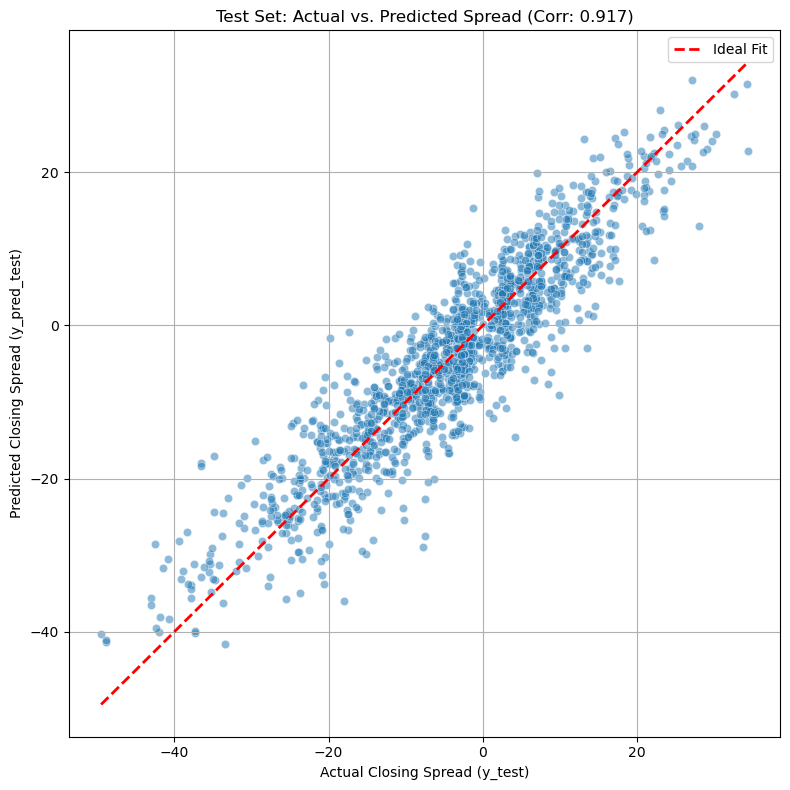


--- Test Set Betting Performance ---
  Total Bets:   1129
  Wins:         596
  Losses:       525
  Pushes:       8
  Win Rate:     53.17%
  Total Units:  +16.76
  ROI:          1.50%


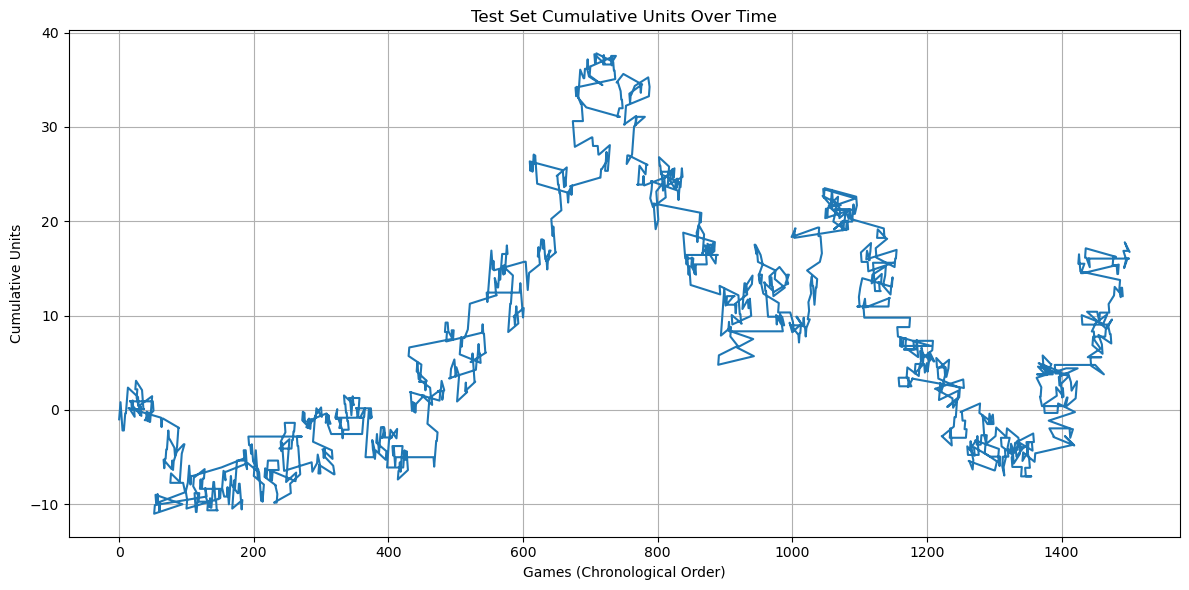

In [26]:
# Evaluate Statistical Metrics on Test Set
win_rate = MF.evaluate_model_statistics(y_test, y_pred_test, predictions_test_series, test_df, VAL_REQUIRED_COLS, WIN_PAYOUT, LOSS_AMOUNT, BET_THRESHOLD)

## Save Final Model

In [34]:
final_model.save_model("final_model.json")